### Compare the effect of new height, CA and AGB parameters

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

import functions_py.fates_xarray_functions as fa

In [2]:
pftnames = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']

###  Load the two fates  runs

In [3]:
fates_allom = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/fbnc_f45_allom_v3.Eb8be65d66e-Ffc130cb8.2023-10-03/run/fbnc_f45_allom_v3.Eb8be65d66e-Ffc130cb8.2023-10-03.2170s.nc'
fates_allom = xr.open_dataset(fates_allom,  decode_times=False)

fates = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/fbnc_f45_allom_v3_defaults.Eb8be65d66e-Ffc130cb8.2023-10-03/run/fbnc_f45_allom_v3_defaults.Eb8be65d66e-Ffc130cb8.2023-10-03.2170s.nc'
fates = xr.open_dataset(fates,  decode_times=False)

time = fates.variables['time'] / 365.
cohort_size_bins = fates.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)

### Veg C by pft

In [4]:
vegc_pft_allom = fates_allom.FATES_VEGC_PF.mean(dim='time') * fates_allom.FATES_FRACTION.mean(dim='time')
vegc_pft = fates.FATES_VEGC_PF.mean(dim='time') * fates.FATES_FRACTION.mean(dim='time')

#### Old allometries

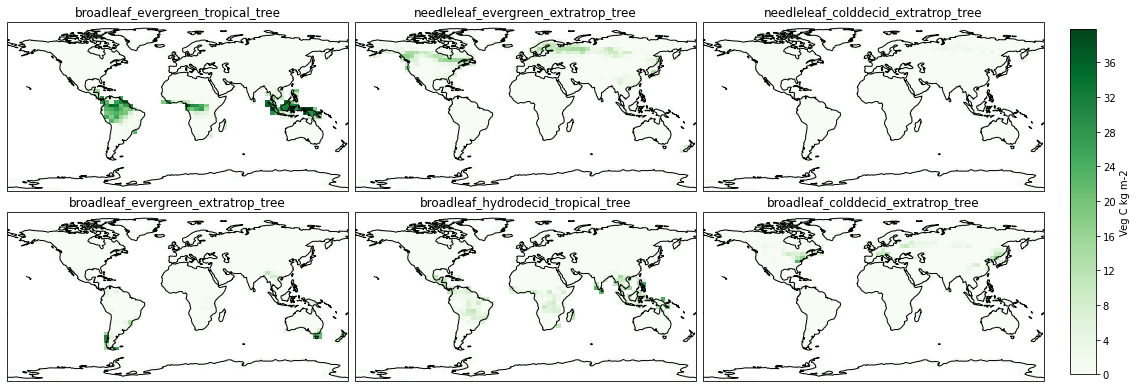

In [5]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,40,0.1)
fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,8))
axs=axs.flatten()
for i in range(0,6):
        cs= vegc_pft.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens',
        ax=axs[i],add_colorbar=False)
        axs[i].set_title(pftnames[i])
        axs[i].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Veg C kg m-2')


#### New allometries

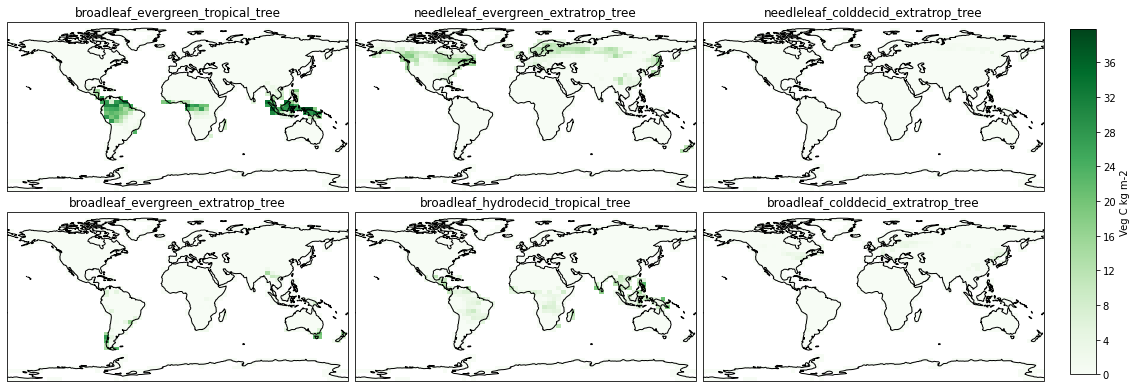

In [6]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,40,0.1)
fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,8))
axs=axs.flatten()
for i in range(0,6):
        cs= vegc_pft_allom.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens',
        ax=axs[i],add_colorbar=False)
        axs[i].set_title(pftnames[i])
        axs[i].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Veg C kg m-2')

In [7]:
diff_vegc = vegc_pft_allom - vegc_pft

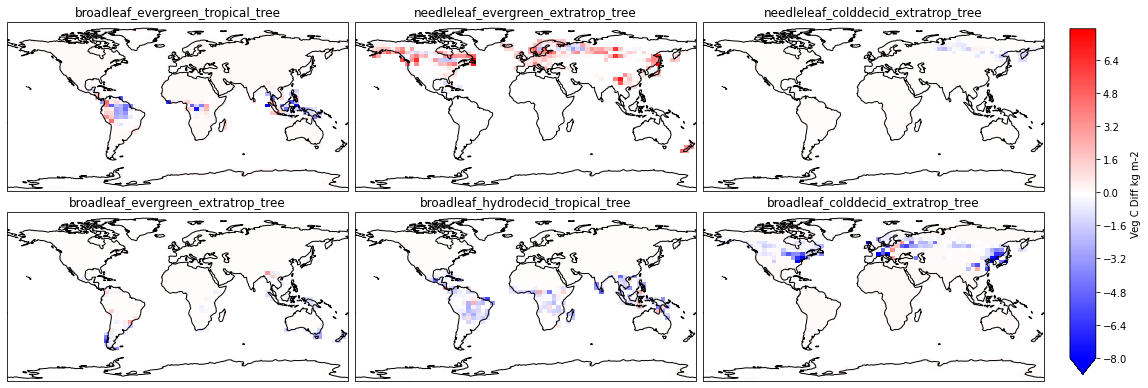

In [8]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(-8.0,8.0,0.1)
fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,8))
axs=axs.flatten()
for i in range(0,6):
        cs= diff_vegc.isel(fates_levpft=i).plot(levels=clevs,cmap='bwr',
        ax=axs[i],add_colorbar=False)
        axs[i].set_title(pftnames[i])
        axs[i].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Veg C Diff kg m-2')

### LAI by pft  

In [9]:
lai_canopy = fa.scpf_to_scls_by_pft(fates.FATES_LAI_CANOPY_SZPF, fates) * fates.FATES_FRACTION.mean(dim='time')
lai_canopy = lai_canopy.sum(dim='fates_levscls').mean(dim='time')
lai_ustory = fa.scpf_to_scls_by_pft(fates.FATES_LAI_USTORY_SZPF, fates) * fates.FATES_FRACTION.mean(dim='time')
lai_ustory = lai_ustory.sum(dim='fates_levscls').mean(dim='time')
lai = lai_canopy+lai_ustory

lai_canopy_allom = fa.scpf_to_scls_by_pft(fates_allom.FATES_LAI_CANOPY_SZPF, fates_allom) * fates_allom.FATES_FRACTION.mean(dim='time')
lai_canopy_allom = lai_canopy_allom.sum(dim='fates_levscls').mean(dim='time')
lai_ustory_allom = fa.scpf_to_scls_by_pft(fates_allom.FATES_LAI_USTORY_SZPF, fates_allom) * fates_allom.FATES_FRACTION.mean(dim='time')
lai_ustory_allom = lai_ustory_allom.sum(dim='fates_levscls').mean(dim='time')
lai_allom = lai_canopy_allom + lai_ustory_allom

#### Old allometries

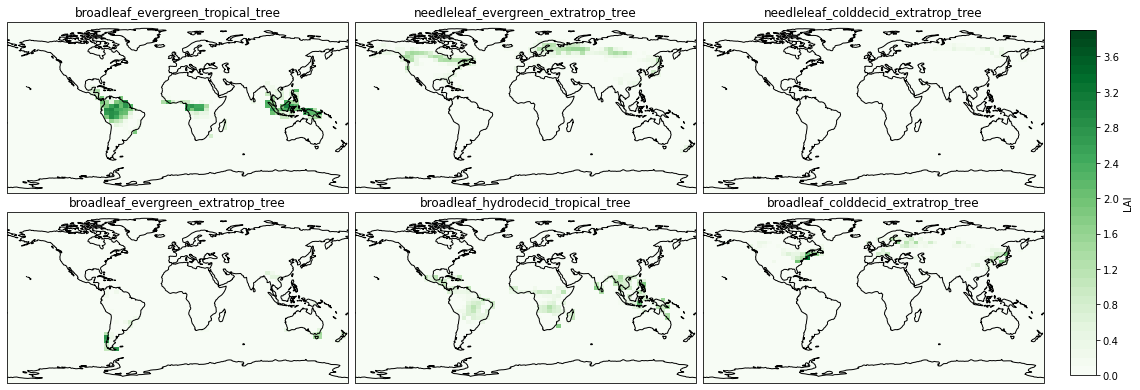

In [10]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,4,0.1)
fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,8))
axs=axs.flatten()
for i in range(0,6):
        cs= lai.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens',
        ax=axs[i],add_colorbar=False)
        axs[i].set_title(pftnames[i])
        axs[i].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('LAI')

#### New allometries

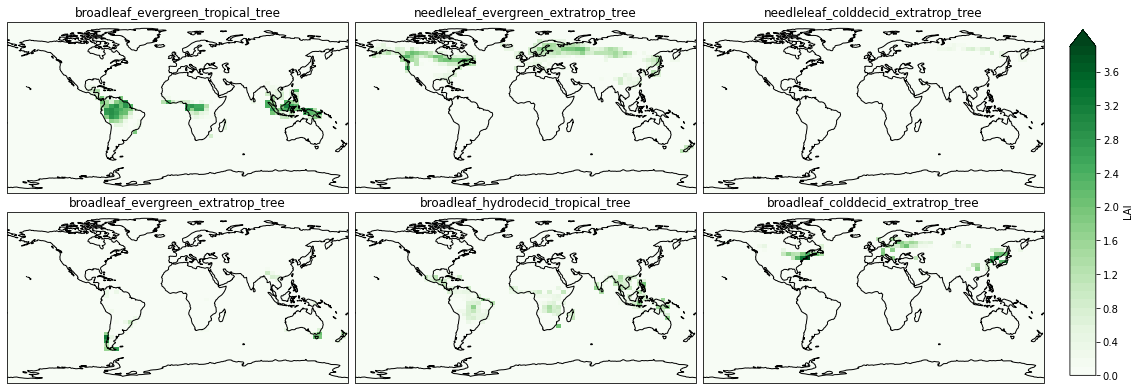

In [11]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,4,0.1)
fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,8))
axs=axs.flatten()
for i in range(0,6):
        cs= lai_allom.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens',
        ax=axs[i],add_colorbar=False)
        axs[i].set_title(pftnames[i])
        axs[i].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('LAI')

### difference new - old

In [12]:
diff = lai_allom - lai

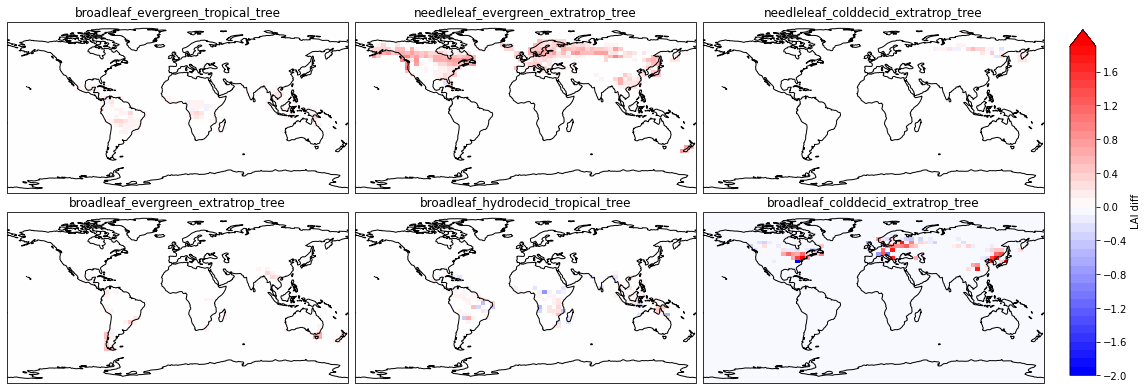

In [13]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(-2,2,0.1)
fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,8))
axs=axs.flatten()
for i in range(0,6):
        cs= diff.isel(fates_levpft=i).plot(levels=clevs,cmap='bwr',
        ax=axs[i],add_colorbar=False)
        axs[i].set_title(pftnames[i])
        axs[i].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('LAI diff')

###  total LAI v ilamb

In [14]:
fates_lai = fates_allom.FATES_LAI.mean(dim='time') * fates_allom.FATES_FRACTION.mean(dim='time')

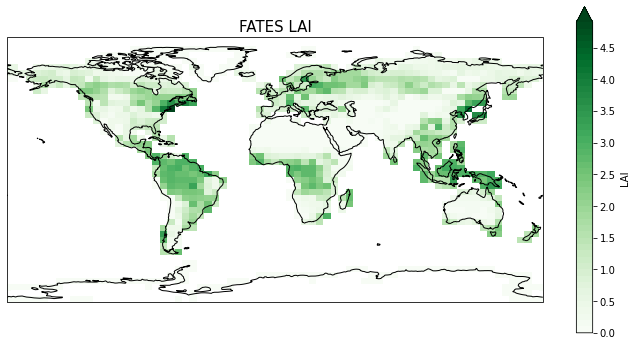

In [15]:
fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,6))

clevs = np.arange(0.,5,0.1)

fates_lai.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "LAI"}, ax=f2ax0)
f2ax0.coastlines()
f2ax0.set_title('FATES LAI', fontsize=15)
cbar.set_label('LAI')

In [16]:
ilamb_lai =  '/pscratch/sd/j/jneedham/ILAMB/DATA/lai/MODIS/lai_0.5x0.5.nc'
ilamb_lai = xr.open_dataset(ilamb_lai, decode_times=False)
ilamb_lai = ilamb_lai.lai 
ilamb_lai_tmean = ilamb_lai.mean(dim='time')

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'lai' has multiple fill values {1e+36, -999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Text(0.5, 1.0, 'ILAMB (MODIS) LAI')

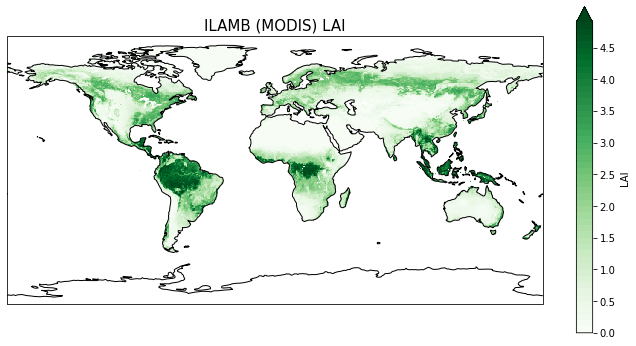

In [17]:
fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,6))

clevs = np.arange(0.,5,0.1)
ilamb_lai_tmean.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "LAI"}, ax=f2ax0)
f2ax0.coastlines()
f2ax0.set_title('ILAMB (MODIS) LAI', fontsize=15)

### Aboveground biomass v ILAMB

In [18]:
### Note this is aboveground biomass (not carbon) only!
ilamb_biomass =  '/pscratch/sd/j/jneedham/ILAMB/DATA/biomass/ESACCI/biomass.nc'
ilamb_biomass = xr.open_dataset(ilamb_biomass, decode_times=False)
ilamb_biomass = ilamb_biomass.biomass / 10 # convert Megagrams ha-1 to kg m-2
ilamb_biomass_tmean = ilamb_biomass.mean(dim='time')

In [19]:
fates_AGB = fates_allom.FATES_VEGC_ABOVEGROUND_SZPF.sum(dim='fates_levscpf') * fates_allom.FATES_FRACTION.mean(dim='time')
fates_AGB = fates_AGB.mean(dim='time')
fates_AGB = fates_AGB * 2

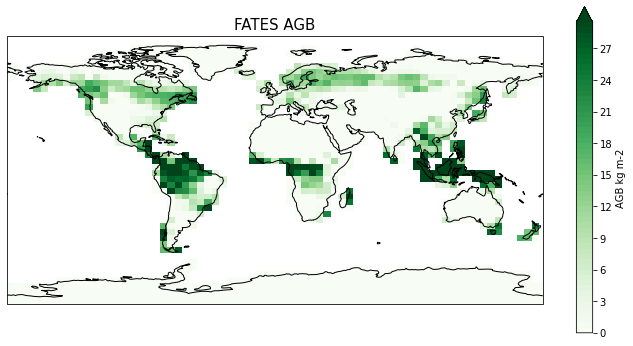

In [20]:
fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,6))

clevs = np.arange(0.,30.,0.5)

fates_AGB.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "AGB kg m-2"}, ax=f2ax0)
f2ax0.coastlines()
f2ax0.set_title('FATES AGB', fontsize=15)
cbar.set_label('AGB kg m-2')

Text(0.5, 1.0, 'ILAMB (ESACCI) AGB')

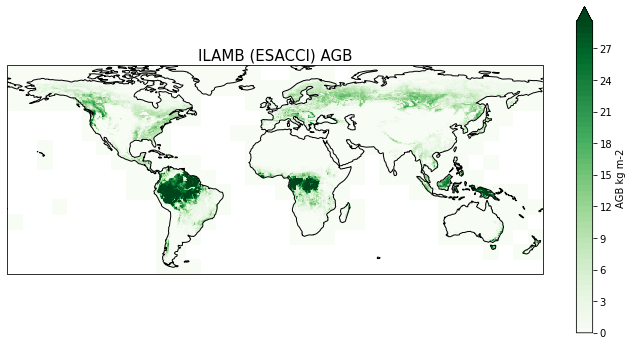

In [21]:
fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,6))

clevs = np.arange(0.,30.,0.5)
ilamb_biomass_tmean.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "AGB kg m-2"}, ax=f2ax0)
f2ax0.coastlines()
f2ax0.set_title('ILAMB (ESACCI) AGB', fontsize=15)

### CUE - just the new allometries

In [22]:
gpp = fates_allom.FATES_GPP_PF.mean(dim='time') * 365 * 86400
npp = fa.scpf_to_scls_by_pft(fates_allom.FATES_NPP_SZPF, fates_allom).sum('fates_levscls') * 365 * 86400
npp = npp.mean(dim='time')
cue = npp/gpp

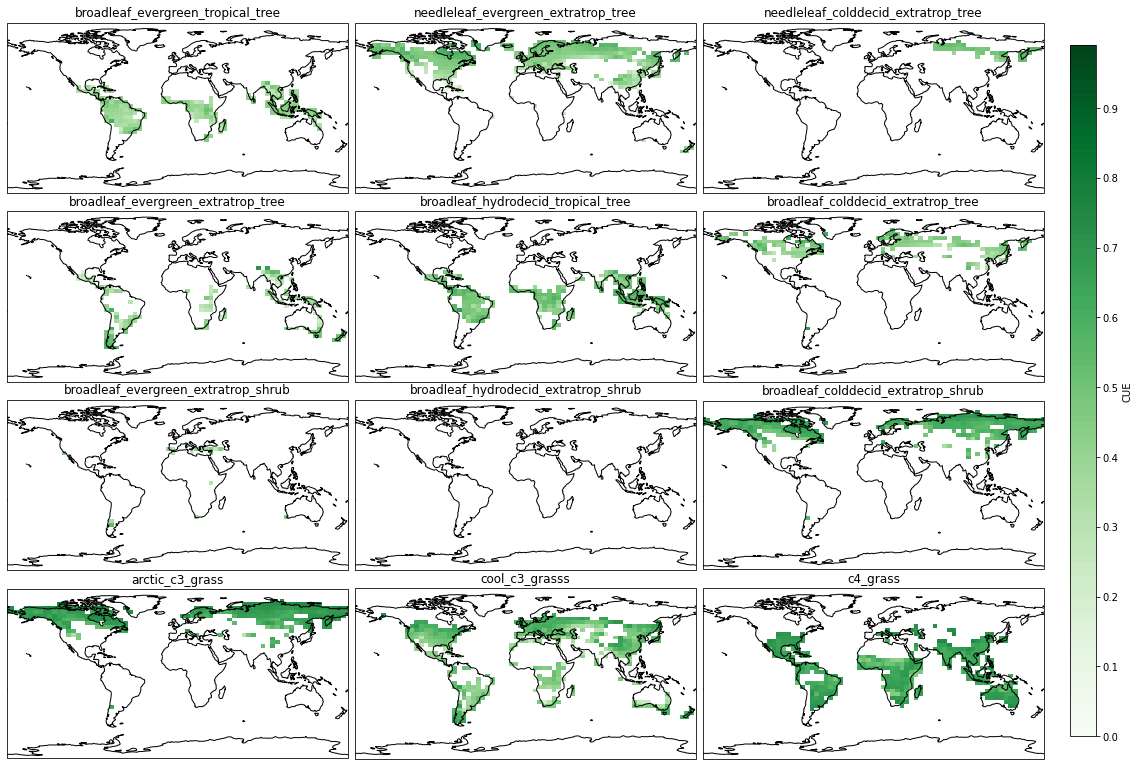

In [23]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,1.0,0.01)
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,16))
axs=axs.flatten()
for i in range(0,12):
        cs= cue.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens',
        ax=axs[i],add_colorbar=False)
        axs[i].set_title(pftnames[i])
        axs[i].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('CUE')